# Centralized Baseline — Diabetes Prediction

This notebook trains a simple neural network on the full (centralized) Pima Indians Diabetes dataset.  
It serves as the **baseline** to compare against federated approaches.

In [9]:
import copy

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

## 1. Load & Explore Data

In [10]:
df = pd.read_csv('../data/diabetes.csv')
print(df.head())
print()
print("Class distribution:")
print(df['Outcome'].value_counts(normalize=True))

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  

Class distribution:
Outcome
0    0.651042
1    0.348958
Name: proportion, dtype: float64


## 2. Preprocessing

1. Train / Validation / Test split (64% / 16% / 20%)  
2. Replace biologically impossible zeros with NaN, then impute with **training medians**  
3. Standardize features  
4. Convert to PyTorch tensors & DataLoaders

In [11]:
X = df.drop('Outcome', axis=1)
y = df['Outcome'].values

# --- Split: first into train+val (80%) vs test (20%) ----------------------
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

# --- Then split train+val into train (80%) vs val (20%) -------------------
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.2, random_state=SEED, stratify=y_trainval
)

# Avoid SettingWithCopyWarning
X_train = X_train.copy()
X_val   = X_val.copy()
X_test  = X_test.copy()

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

# --- Impute zeros → NaN → median (train medians only) ---------------------
cols_with_zero_as_missing = [
    "Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"
]

for split in [X_train, X_val, X_test]:
    split[cols_with_zero_as_missing] = split[cols_with_zero_as_missing].replace(0, np.nan)

# Compute medians from TRAINING set only (class-agnostic for val/test)
train_medians = X_train[cols_with_zero_as_missing].median()

# Class-conditional imputation for training set (optional, but reasonable)
for col in cols_with_zero_as_missing:
    med_0 = X_train[y_train == 0][col].median()
    med_1 = X_train[y_train == 1][col].median()
    X_train.loc[y_train == 0, col] = X_train.loc[y_train == 0, col].fillna(med_0)
    X_train.loc[y_train == 1, col] = X_train.loc[y_train == 1, col].fillna(med_1)

# For val/test: use class-AGNOSTIC training medians (no label leakage)
X_val  = X_val.fillna(train_medians)
X_test = X_test.fillna(train_medians)

print("Missing values after imputation:")
print("  Train:", X_train.isna().sum().sum())
print("  Val:  ", X_val.isna().sum().sum())
print("  Test: ", X_test.isna().sum().sum())

# --- Standardize -----------------------------------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

# --- To tensors & DataLoaders ----------------------------------------------
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_val_t   = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_t   = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
X_test_t  = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_t  = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

BATCH_SIZE = 32
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val_t, y_val_t),     batch_size=BATCH_SIZE, shuffle=False)

Train: 491, Val: 123, Test: 154
Missing values after imputation:
  Train: 0
  Val:   0
  Test:  0


## 3. Model Definition

In [13]:
class DiabetesNet(nn.Module):
    def __init__(self, dropout_rate=0.15):
        super().__init__()
        self.fc1 = nn.Linear(8, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.fc3(x)          # raw logits — no sigmoid here
        return x


model     = DiabetesNet()
n_pos = y_train.sum()
n_neg = len(y_train) - n_pos
pos_weight = torch.tensor([n_neg / n_pos])   # ≈ 1.86
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)         # numerically stable
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=5
)

## 4. Training with Early Stopping

In [14]:
MAX_EPOCHS = 150
PATIENCE   = 15

best_model = None
best_auc   = -1
counter    = 0

for epoch in range(MAX_EPOCHS):
    # ---- Train ----
    model.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # ---- Validate ----
    model.eval()
    val_preds, val_labels_list = [], []
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            logits = model(inputs)
            val_loss += criterion(logits, labels).item()
            probs = torch.sigmoid(logits)        # apply sigmoid for metrics
            val_preds.extend(probs.numpy().flatten())
            val_labels_list.extend(labels.numpy().flatten())

    val_auc = roc_auc_score(val_labels_list, val_preds)
    scheduler.step(val_auc)  # reduce LR if AUC plateaus
    print(
        f"Epoch {epoch+1:3d}/{MAX_EPOCHS} | "
        f"Train Loss: {train_loss/len(train_loader):.4f} | "
        f"Val Loss: {val_loss/len(val_loader):.4f} | "
        f"Val AUC: {val_auc:.4f}"
    )

    # ---- Early Stopping ----
    if val_auc > best_auc:
        best_auc   = val_auc
        best_model = copy.deepcopy(model)
        counter    = 0
    else:
        counter += 1
        if counter >= PATIENCE:
            print(f"\nEarly stopping at epoch {epoch+1}  (best Val AUC: {best_auc:.4f})")
            break

# Restore best model
model = best_model

Epoch   1/150 | Train Loss: 0.9024 | Val Loss: 0.8822 | Val AUC: 0.7468
Epoch   2/150 | Train Loss: 0.8766 | Val Loss: 0.8531 | Val AUC: 0.8355
Epoch   3/150 | Train Loss: 0.8505 | Val Loss: 0.8175 | Val AUC: 0.8529
Epoch   4/150 | Train Loss: 0.8159 | Val Loss: 0.7726 | Val AUC: 0.8628
Epoch   5/150 | Train Loss: 0.7674 | Val Loss: 0.7225 | Val AUC: 0.8637
Epoch   6/150 | Train Loss: 0.7246 | Val Loss: 0.6708 | Val AUC: 0.8666
Epoch   7/150 | Train Loss: 0.6952 | Val Loss: 0.6310 | Val AUC: 0.8706
Epoch   8/150 | Train Loss: 0.6455 | Val Loss: 0.6055 | Val AUC: 0.8703
Epoch   9/150 | Train Loss: 0.6332 | Val Loss: 0.5922 | Val AUC: 0.8715
Epoch  10/150 | Train Loss: 0.6226 | Val Loss: 0.5786 | Val AUC: 0.8756
Epoch  11/150 | Train Loss: 0.6029 | Val Loss: 0.5757 | Val AUC: 0.8721
Epoch  12/150 | Train Loss: 0.6115 | Val Loss: 0.5726 | Val AUC: 0.8730
Epoch  13/150 | Train Loss: 0.5839 | Val Loss: 0.5750 | Val AUC: 0.8709
Epoch  14/150 | Train Loss: 0.5770 | Val Loss: 0.5742 | Val AUC:

## 5. Evaluation on Test Set

In [15]:
def evaluate_model(model, X_t, y_true):
    """Evaluate a trained model and print classification metrics."""
    model.eval()
    with torch.no_grad():
        logits     = model(X_t).numpy().flatten()
        y_pred_prob = 1.0 / (1.0 + np.exp(-logits))   # sigmoid on logits
        y_pred      = (y_pred_prob > 0.5).astype(int)

    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("ROC-AUC: ", roc_auc_score(y_true, y_pred_prob))
    print(classification_report(y_true, y_pred))
    return y_pred_prob, y_pred


print("=" * 50)
print("Final Test Results (best early-stopped model)")
print("=" * 50)
y_pred_prob, y_pred = evaluate_model(model, X_test_t, y_test)

Final Test Results (best early-stopped model)
Accuracy: 0.7012987012987013
ROC-AUC:  0.787037037037037
              precision    recall  f1-score   support

           0       0.85      0.66      0.74       100
           1       0.55      0.78      0.65        54

    accuracy                           0.70       154
   macro avg       0.70      0.72      0.69       154
weighted avg       0.74      0.70      0.71       154



## 6. SHAP Feature Importance

  0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\lenovo\AppData\Local\Temp\ipykernel_28276\3605319305.py:22: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


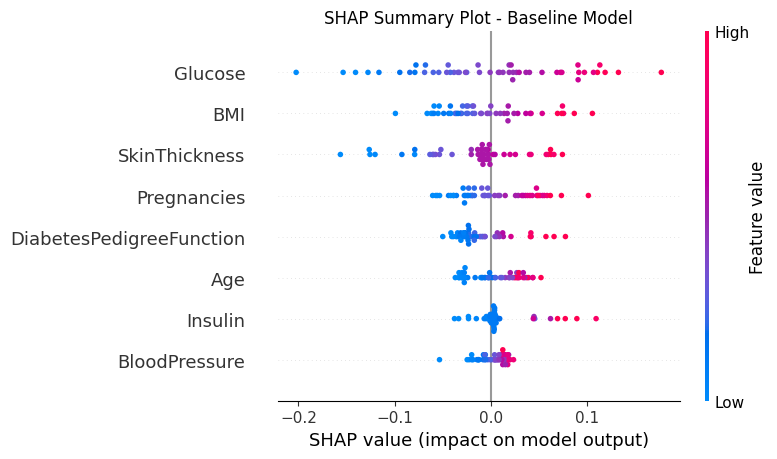

In [8]:
import shap
import matplotlib.pyplot as plt

# Background: use first 100 training samples
background = X_train_t[:100].numpy()

def model_predict_proba_numpy(data):
    """Wrapper that returns probabilities from raw numpy input."""
    model.eval()
    data_t = torch.tensor(data, dtype=torch.float32)
    with torch.no_grad():
        logits = model(data_t).numpy().flatten()
    return 1.0 / (1.0 + np.exp(-logits))   # sigmoid

# Create explainer
explainer = shap.KernelExplainer(model_predict_proba_numpy, background)

# Compute SHAP values on a subset of test data
shap_values = explainer.shap_values(X_test_scaled[:50])

# Summary plot
shap.summary_plot(
    shap_values, X_test_scaled[:50],
    feature_names=df.columns[:-1],
    show=False
)
plt.title("SHAP Summary Plot - Baseline Model")
plt.tight_layout()
plt.savefig('../results/shap_summary_baseline.png')
plt.show()